In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [2]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [70.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [819 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:11 https://developer.download.nvidia.com/c

In [0]:
annots

#filename  ...                                   url
0     1.jpg  ...  drive/My Drive/OCR/dl/original/1.jpg
1     1.jpg  ...  drive/My Drive/OCR/dl/original/1.jpg
2     2.png  ...  drive/My Drive/OCR/dl/original/2.png
3     2.png  ...  drive/My Drive/OCR/dl/original/2.png
4     3.png  ...  drive/My Drive/OCR/dl/original/3.png
5     3.png  ...  drive/My Drive/OCR/dl/original/3.png
6     4.png  ...  drive/My Drive/OCR/dl/original/4.png
7     4.png  ...  drive/My Drive/OCR/dl/original/4.png
8     5.png  ...  drive/My Drive/OCR/dl/original/5.png
9     5.png  ...  drive/My Drive/OCR/dl/original/5.png

[10 rows x 5 columns]

In [0]:

import numpy as np 
import pandas as pd 
path = 'drive/My Drive/OCR/dl/'

from ast import literal_eval

def expand_attributes(df,add):
  df = pd.concat([df.drop('region_shape_attributes',1), df['region_shape_attributes'].apply(literal_eval).apply(pd.Series)],1)
  df = df.drop(['file_size', 'file_attributes', 'region_count', 'region_attributes', 'name'],1)
  df['url'] = path+'original/'+df['#filename']
  df['region_id']+=add
  return df

In [19]:
import os
os.listdir(path)

['annotation.csv',
 'original',
 'masks',
 'resized',
 'resnet_unet_1',
 'resnet_unet_1_config.json',
 'finalized_model.sav',
 'jaipur.csv',
 'culcutta.csv']

In [0]:
annots = pd.concat([expand_attributes(pd.read_csv(f'{path}{i}.csv'),j) for i,j in zip(['jaipur','culcutta'],[1,3])],0).reset_index(drop=True) 


In [4]:
annots.loc[(annots['region_id']%2 == 1)]

#filename  ...                                                url
0                                       1.jpg  ...               drive/My Drive/OCR/dl/original/1.jpg
2                                       2.png  ...               drive/My Drive/OCR/dl/original/2.png
4                                       3.png  ...               drive/My Drive/OCR/dl/original/3.png
6                                       4.png  ...               drive/My Drive/OCR/dl/original/4.png
8                                       5.png  ...               drive/My Drive/OCR/dl/original/5.png
10         IMG_20190704_190734 - Joy Shaw.jpg  ...  drive/My Drive/OCR/dl/original/IMG_20190704_19...
12  IMG20190704191933 - ABHISHEK AGRAHARI.jpg  ...  drive/My Drive/OCR/dl/original/IMG201907041919...

[7 rows x 5 columns]

In [21]:

zero = annots.loc[(annots['region_id']%2 == 1)].index

# Resize the image maintaining the aspect rato 
def resize_image(image, width=32*18, height = 32*24, to_gray= False):
#   image = cv2.imread(url)
  if to_gray:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  if image.shape[1]<image.shape[0]:  
    new_height = height
    new_width  = new_height * image.shape[1] / image.shape[0]
  else: 
    new_width = width
    new_height  = new_width * image.shape[0] / image.shape[1]
  return cv2.resize(image, (int(new_width), int(new_height)))

# Make the image size constant by padding 0's to the image 
def pad_zeros(image,width=(32*18),height = (32*24)):
  result = np.zeros((height,width,3))
  image = image[:height,:width]
  result[:image.shape[0],:image.shape[1]] = image
  return result



import cv2
from google.colab.patches import cv2_imshow

for l in zero:    
  # Read image
  img = cv2.imread(annots['url'][l])
  # Create a mask 
  mask = np.zeros(img.shape[:2],dtype = 'uint8')

  for i in [l,l+1]:
      # Store x and y coordinates 
      c = annots['all_points_x'][i]
      r = annots['all_points_y'][i]
      rid = annots['region_id'][i]
      rc = np.array((c,r)).T
      # Draw contours on mask 
      cv2.drawContours(mask,[rc],0,int(rid),-1)
      # Make mask 3 dimenational 
      
  # Stack the image and mask for visualization
  mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
 
  original_url = path+'resized/original/' + annots['#filename'][l].split('.')[0]+'.png'
  mask_url = path+'resized/masks/'+ annots['#filename'][l].split('.')[0]+'.png'
  img = pad_zeros(resize_image(img))
  mask = pad_zeros(resize_image(mask))
  cv2.imwrite(original_url, img)
  cv2.imwrite(mask_url, mask)
  
  
import os 
import imutils

img = os.listdir(path+'resized/original/')
images = [cv2.imread(path+'resized/original/'+i) for i in img]
masks = [cv2.imread(path+'resized/masks/'+i) for i in img]

org = path+'resized/augmented/original/'
mas = path+'resized/augmented/masks/'
  
def augment(img,mask,n): 
  for i in [100,150,200,250,300,400,500,32*24]:
    image = img[:i]
    ma = mask[:i] 
    for angle in np.arange(0, 180, 15):
      rotated = pad_zeros(resize_image(imutils.rotate_bound(image, angle))) 
      cv2.imwrite(org+ f'{n}_x_{i}_rotated_{angle}.png',rotated)
      rotated = pad_zeros(resize_image(imutils.rotate_bound(ma, angle))) 
      cv2.imwrite(mas+ f'{n}_x_{i}_rotated_{angle}.png',rotated)

  for i in [250,300,32*18]:
    image = img[:,:i]
    ma = mask[:,:i]  
    for angle in np.arange(0, 180, 15):
      rotated = pad_zeros(resize_image(imutils.rotate_bound(image, angle))) 
      cv2.imwrite(org+f'{n}_y_{i}_rotated_{angle}.png',rotated)
      rotated = pad_zeros(resize_image(imutils.rotate_bound(ma, angle))) 
      cv2.imwrite(mas+f'{n}_y_{i}_rotated_{angle}.png',rotated)  
  return n
    
main = []
for n,(i,j) in enumerate(zip(images,masks)):
  print(n)
  main.append(augment(i,j,n))
  
!pip install keras_segmentation
import keras_segmentation


0
1
2
3
4
5
6


In [0]:

# import shutil
# img_list = np.array(os.listdir(org))
# a = np.arange(len(img_list))
# np.random.shuffle(a)
validation_data = img_list[a[:30]]

for i in validation_data:
  try:
    shutil.move(org+i, f'{path}/resized/augmented/val_original/'+i)
    shutil.move(mas+i, f'{path}/resized/augmented/val_mask/'+i)
  except:
    continue 


In [24]:
os.listdir(f'{path}/resized/augmented/val_original/')

['0_x_100_rotated_120.png',
 '0_x_150_rotated_165.png',
 '0_x_250_rotated_150.png',
 '0_x_500_rotated_105.png',
 '0_y_300_rotated_165.png',
 '1_x_250_rotated_105.png',
 '1_x_500_rotated_15.png',
 '1_y_250_rotated_75.png',
 '2_x_768_rotated_105.png',
 '2_y_576_rotated_30.png',
 '3_x_150_rotated_90.png',
 '3_x_300_rotated_105.png',
 '3_x_768_rotated_165.png',
 '4_y_250_rotated_105.png',
 '4_y_576_rotated_45.png',
 '0_x_400_rotated_45.png',
 '2_x_300_rotated_0.png',
 '5_x_250_rotated_75.png',
 '5_x_300_rotated_0.png',
 '5_x_300_rotated_75.png',
 '5_x_768_rotated_60.png',
 '5_x_768_rotated_150.png',
 '5_y_300_rotated_0.png',
 '5_y_300_rotated_105.png',
 '6_x_100_rotated_0.png',
 '6_x_150_rotated_90.png',
 '6_x_300_rotated_150.png',
 '6_y_250_rotated_60.png',
 '6_y_576_rotated_120.png',
 '2_y_250_rotated_105.png']

In [25]:
  
  
model = keras_segmentation.models.unet.resnet50_unet(n_classes=5,  input_height=32*24, input_width=32*18,)

model.train(train_images =  org, 
            train_annotations = mas, 
            checkpoints_path = path+"resnet_unet_1" , 
            epochs=5, 
            steps_per_epoch=256, 
            batch_size=2, 
            validate=True,
            val_images = path+'resized/augmented/val_original/',
            val_annotations=path+'resized/augmented/val_mask')

  1%|          | 6/894 [00:00<00:16, 55.30it/s]

Verifying train dataset


 17%|█▋        | 5/30 [00:00<00:00, 46.41it/s]

Dataset verified! 
Verifying val dataset


100%|██████████| 30/30 [00:00<00:00, 45.99it/s]


Dataset verified! 
Starting Epoch  0
Epoch 1/1
128/128 [==============================] - 190s 1s/step - loss: 0.6632 - acc: 0.8344 - val_loss: 7.8530 - val_acc: 0.1824
saved  drive/My Drive/OCR/dl/resnet_unet_1.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
128/128 [==============================] - 177s 1s/step - loss: 0.2720 - acc: 0.9090 - val_loss: 0.4989 - val_acc: 0.9266
saved  drive/My Drive/OCR/dl/resnet_unet_1.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
128/128 [==============================] - 177s 1s/step - loss: 0.2135 - acc: 0.9268 - val_loss: 0.2139 - val_acc: 0.9006
saved  drive/My Drive/OCR/dl/resnet_unet_1.model.2
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
128/128 [==============================] - 177s 1s/step - loss: 0.1507 - acc: 0.9488 - val_loss: 0.0809 - val_acc: 0.9771
saved  drive/My Drive/OCR/dl/resnet_unet_1.model.3
Finished Epoch 3
Starting Epoch  4
Epoch 1/1
128/128 [==============================] - 177s 1s/step - loss: 0.1241 - acc: 0.9

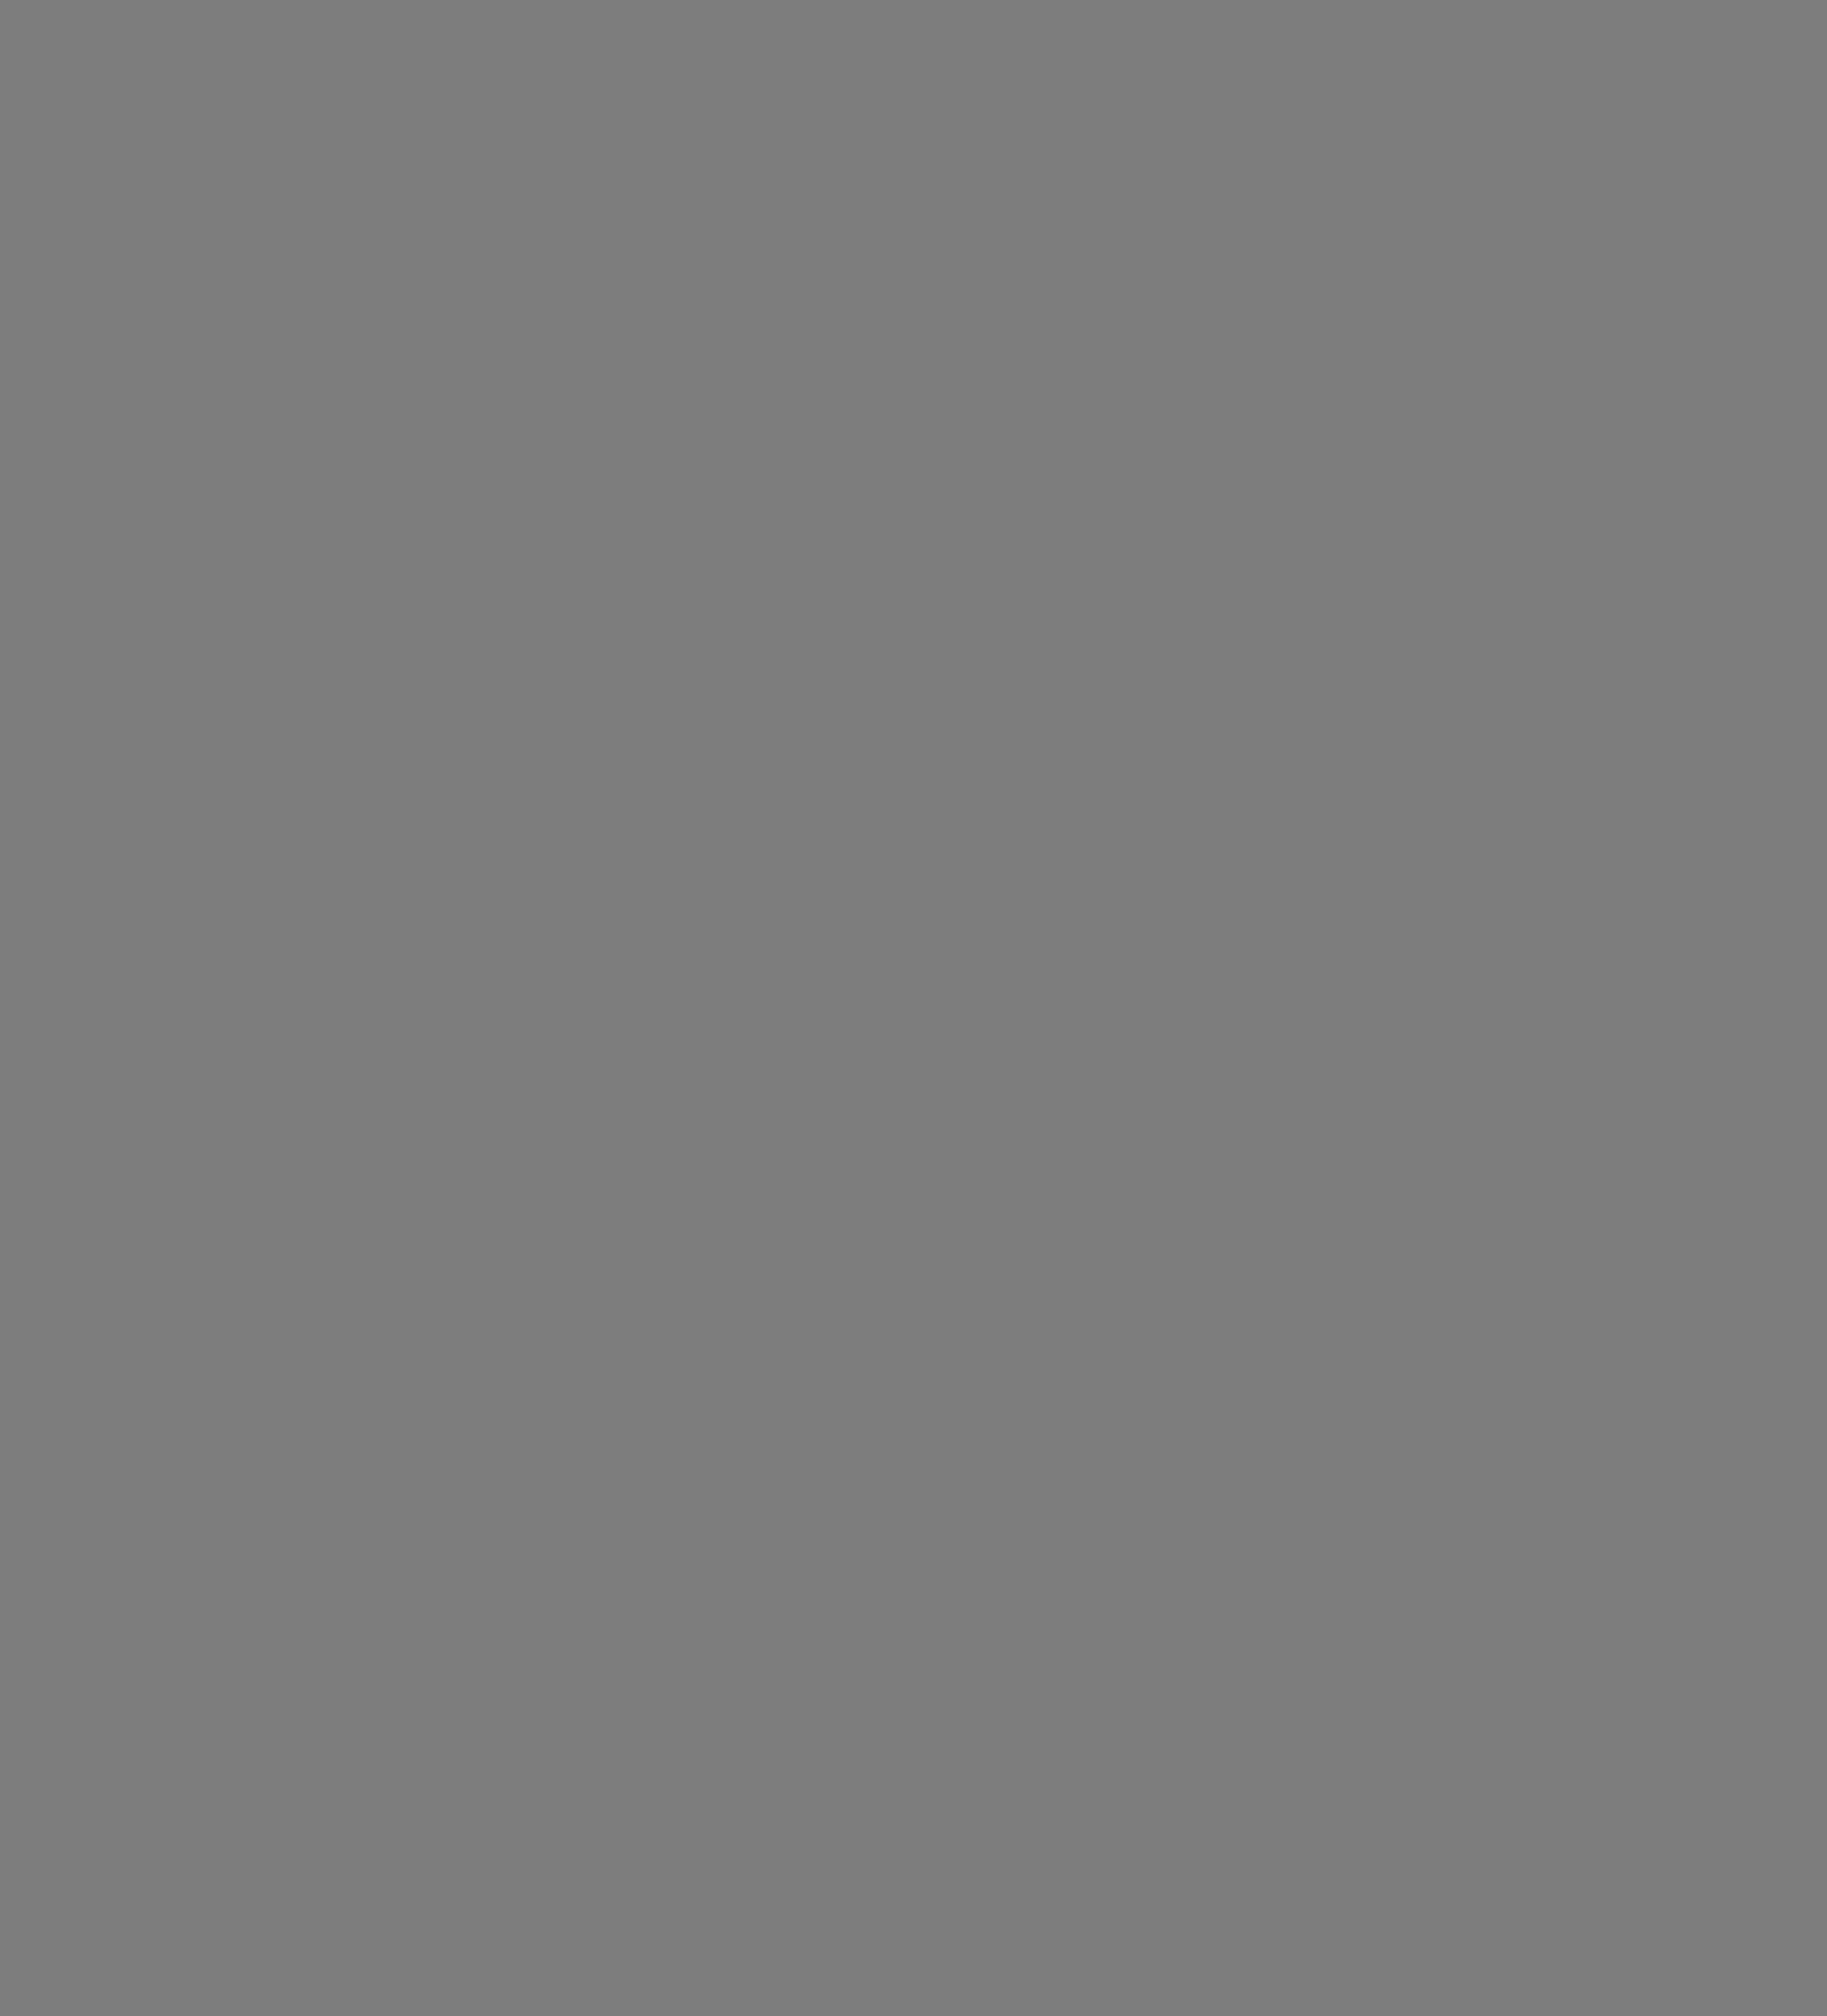

[]


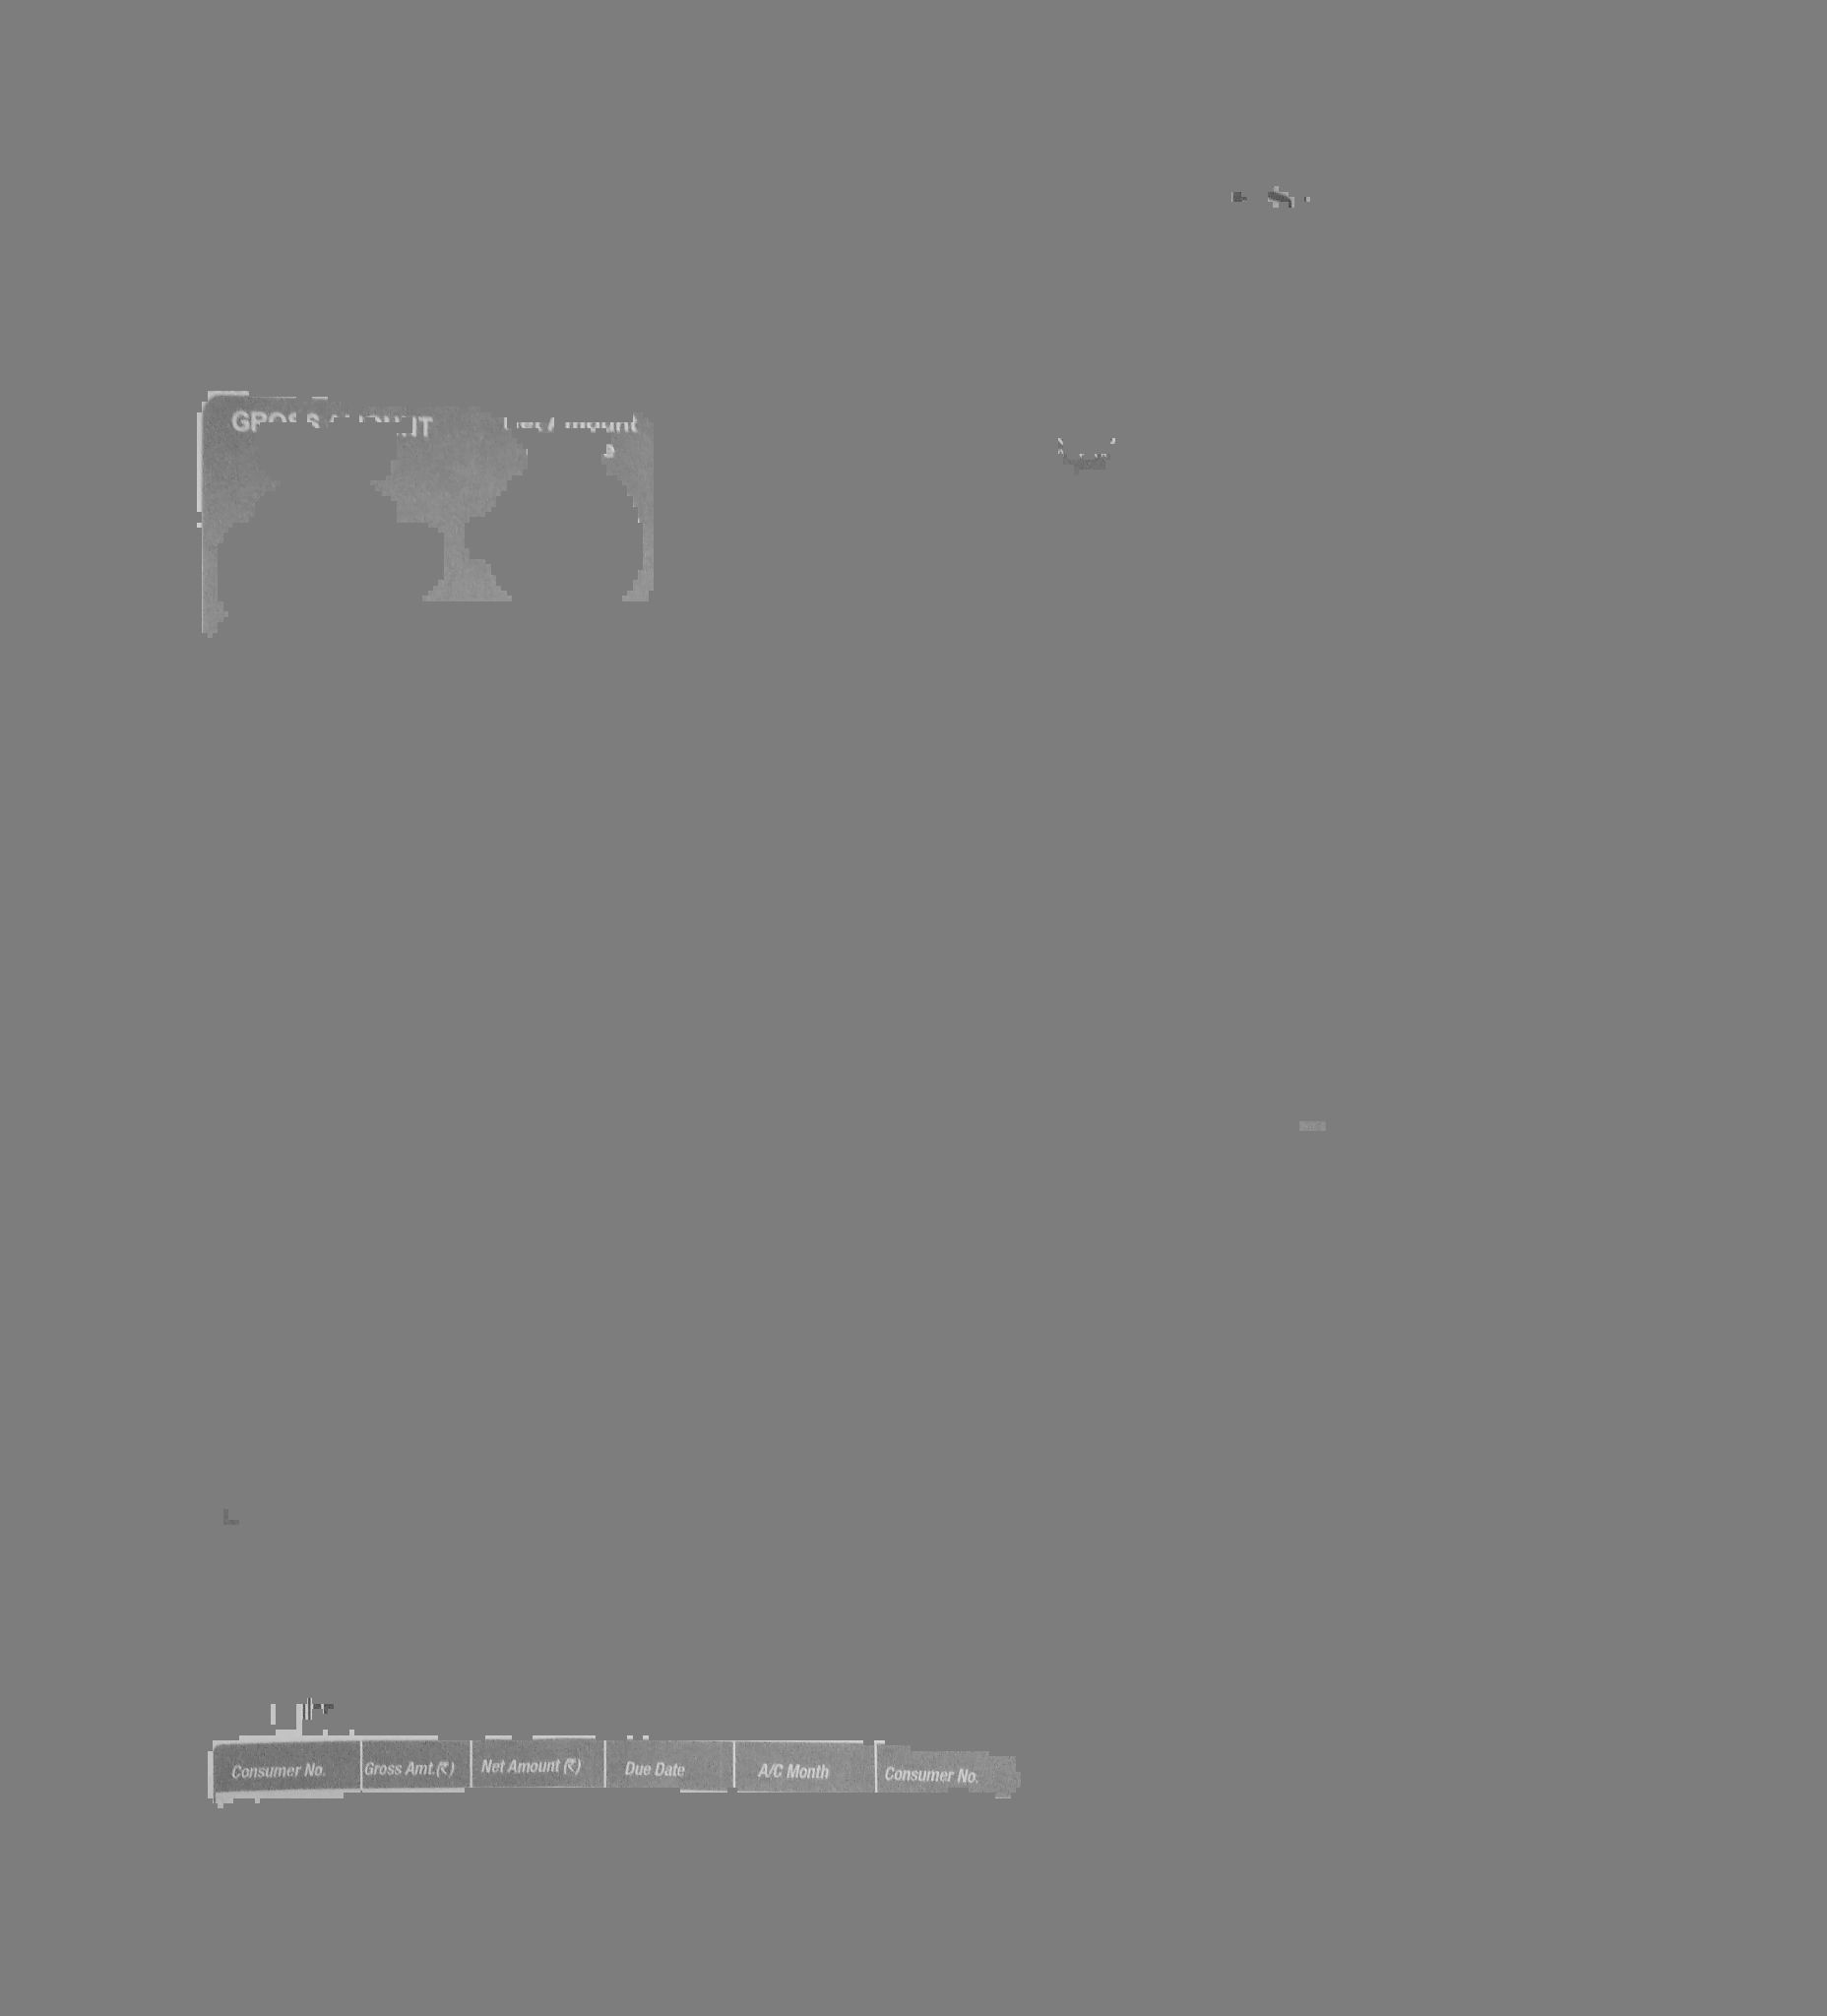

[]


In [38]:
import pytesseract
import re 

# for i in os.listdir(f'{path}/original/'):  
#   op = model.predict_segmentation(cv2.imread(f'{path}/original/{i}')).astype('float32')
#   op = cv2.cvtColor(op,cv2.COLOR_GRAY2BGR)
#   res = resize_image(cv2.imread(f'{path}/original/{i}'),width=32*58,height=32*64)
#   im = pad_zeros(res,width=32*58,height=32*64)
#   cv2_imshow(gray)
#   gray = cv2.cvtColor(np.where(pad_zeros(resize_image(op))==2,im,0).astype('uint8'), cv2.COLOR_BGR2GRAY)
#   thresh1 = cv2.adaptiveThreshold(gray, 105, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 155, 28)
#   print(re.findall('\d{11}',pytesseract.image_to_string(thresh1,config='digits')))


def prepare_for_tesseract(img):	
  res = resize_image(img,width=32*58,height=32*64)
  padded_img = pad_zeros(res,width=32*58,height=32*64)
  return padded_img

def get_details(image_address):
  #Get predictions 
  img = cv2.imread(image_address)		
  op = model.predict_segmentation(img).astype('float32')
  op = cv2.cvtColor(op,cv2.COLOR_GRAY2BGR)
  # preapre image for tesseract
  img = prepare_for_tesseract(img)	
  op = prepare_for_tesseract(op)
  
  unmask = cv2.cvtColor(np.where(op==4,img,125).astype('uint8'),cv2.COLOR_BGR2GRAY)
  # Threshold		
#   thresh = cv2.adaptiveThreshold(unmask, 125,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 155, 10)
#   final = thresh[min(np.where((thresh!=125).any(1))[0]):max(np.where((thresh!=125).any(1))[0])]
  cv2_imshow(unmask)
  return re.findall('\d{12}',pytesseract.image_to_string(unmask,config='digits'))

for i in os.listdir(f'{path}/original/')[-2:]:
  print(get_details(f'{path}/original/{i}'))  


In [35]:
os.listdir(f'{path}/original/')[-2]

'IMG20190704191933 - ABHISHEK AGRAHARI.jpg'

In [39]:
cv2_imshow(cv2.imread(f'{path}/masks/IMG20190704191933 - ABHISHEK AGRAHARI.jpg'))

AttributeError: ignored

In [0]:
import pickle
filename = f'{path}/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))